# Selecting the Most Profitable Oil Well Region with a Machine Learning Model

## Contents <a id='back'></a>
* [1. Introduction](#intro)
* [2. Data Exploration](#data_exploration)
* [3. Exploratory Data Analysis (EDA)](#eda)
    * [3.1 Distribution of the Features Data](#features_data_eda)
    * [3.2 Distribution of the Target Data](#target_data_eda)
    * [3.3 Correlation between the Numerical Data](#numerical_data_eda)
* [4. Development of Models](#models)
    * [4.1 Model Performance and Results](#model_result)
* [5. Profit Calculation and Risk Assessment](#profit_and_risk)
    * [5.1 Conditions and the Key Values](#conditions)
    * [5.2 Minimum Volume of Reserves Per Oil Well Without Losses](#minimum_volume)
    * [5.3 Profit from the 200 Oil Wells with the Highest Predicted Volumes Per Region](#200_wells)
    * [5.4 Distribution of Profit for Each Region](#bootstrapping)
* [6. General Conclusion](#general_conclusion)

## 1. Introduction <a id='intro'></a>
The OilyGiant mining company plans to choose a region and develops new oil wells. This project aims to  select the region with the highest profit margin.

### Purpose

To develop a machine learning model which predicts the volume of reserves in the new wells. By using the prediction in conjuction with the bootstrapping technique, select the oil wells with the highest estimated values and the region with the highest profit for the selected oil wells.

In [1]:
# For data preprocessing and manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# For model building and selection
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## 2. Data Exploration <a id='data_exploration'></a>

The data on oil samples from three regions has been provided by the OilyGiant company. Let's explore the datasets.

In [2]:
# Create a dictianary to store 3 datasets
data = {}

# Create two lists containing the key names and datasets
regions = ['region 1', 'region 2', 'region 3']
datasets = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']

# Use a for loop to load the datasets and store in the dictionary
for i, region in enumerate(regions):
    try:
        data[region] = pd.read_csv(datasets[i])
    except:
        data[region] = pd.read_csv(f'/datasets/{datasets[i]}')

In [3]:
# Look at the first 5 rows and the shape of each dataset
for region in regions:
    print('\033[1m')
    print(region)
    display(data[region].head())
    print('Shape:', data[region].shape, '\n')
    print('*' * 50)


region 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Shape: (100000, 5) 

**************************************************

region 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Shape: (100000, 5) 

**************************************************

region 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Shape: (100000, 5) 

**************************************************


Each of the three datasets (regions) has 100000 rows (oil wells) and 5 columns of information related to each well.

**Description of data**

*Features*
- id — unique oil well identifier
- f0, f1, f2 — three features of points (their specific meaning is not important, but the features themselves are significant to predict the target)

*Target*
- product — volume of reserves in the oil well (thousand barrels)

**Issue needs to be addressed**
- The `id` column provide no information in predicting the volume of reserves and will be excluded from the model training.

In [4]:
# Check for duplicates, missing values and data types
for region in regions:
    print('\033[1m')
    print(region)
    print('Number of duplicates: ', data[region].duplicated().sum())
    print('\033[0m')
    data[region].info()    
    print('\n', '*' * 50)


region 1
Number of duplicates:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 **************************************************

region 2
Number of duplicates:  0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

 *****

All of the three datasets have no duplicate and no missing values. The data types are also correct.

In [5]:
# Look at the descriptic statistics
for region in regions:
    print('\033[1m')
    print(region)
    display(data[region].describe())
    print('*' * 60)


region 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


************************************************************

region 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


************************************************************

region 3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


************************************************************


In all of the three datasets, the means and the medians of the three features `f0`, `f1` and `f2` are almost the same, indicating that the distributions could be normal. There is no obvious anomaly and outlier in the three `product` columns.

[Back to Contents](#back)

## 3. Exploratory Data Analysis (EDA) <a id='eda'></a>

### 3.1 Distribution of the Features Data <a id='features_data_eda'></a>

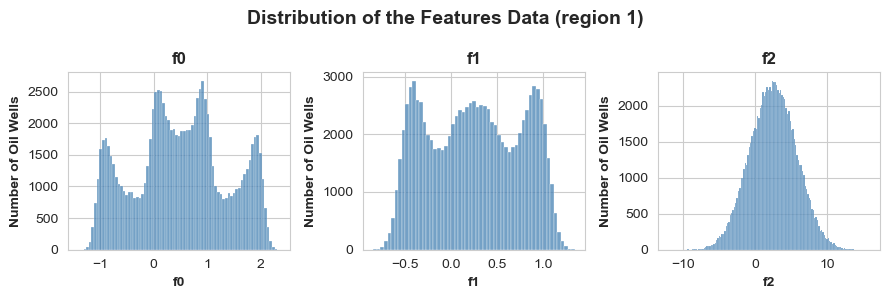

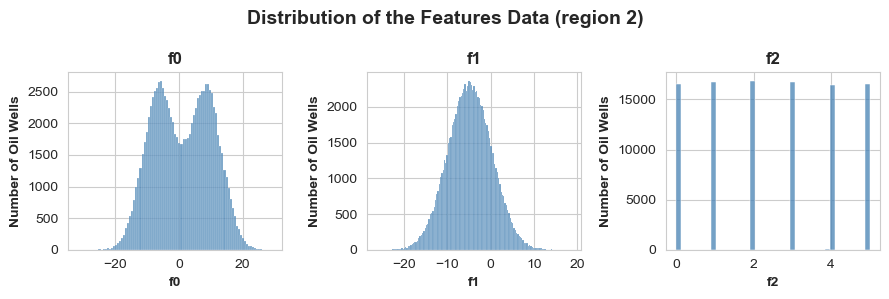

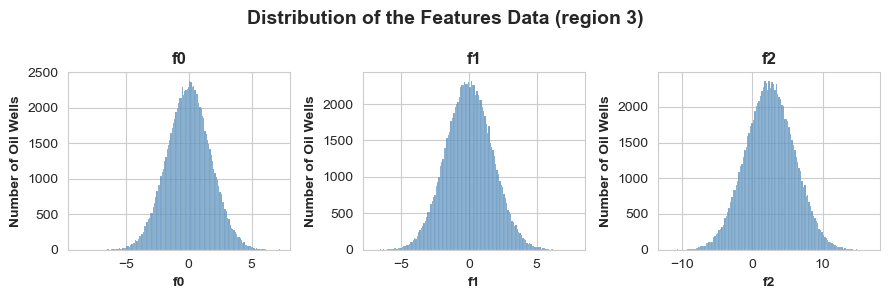

In [6]:
# Plot histograms of the features to show the distribution of features
features = ['f0', 'f1', 'f2']

for region in regions:
    sns.set_style('whitegrid')
    fig, axs = plt.subplots(1, 3, figsize=(9,3))
    
    plt.suptitle(f'Distribution of the Features Data ({region})', fontsize=14, fontweight='bold')
    for i, feature in enumerate(features):
        sns.histplot(x=data[region][feature], color='steelblue', ax=axs[i])
        axs[i].set_title(feature, fontsize=12, fontweight='bold')
        axs[i].set_xlabel(feature, fontweight='bold')
        axs[i].set_ylabel('Number of Oil Wells', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

Five of the features have normal distributions while the rest have some unique distribution shapes. 

In this project, linear regression model will be used to predict the volume of reserves. Although the range of the these features are almost of the same scale (-20 to 20), they will still be apllied with standardisation to (slightly) improve the convergence speed of the gradient descent algorithm.

[Back to Contents](#back)

### 3.2 Distribution of the Target Data <a id='target_data_eda'></a>

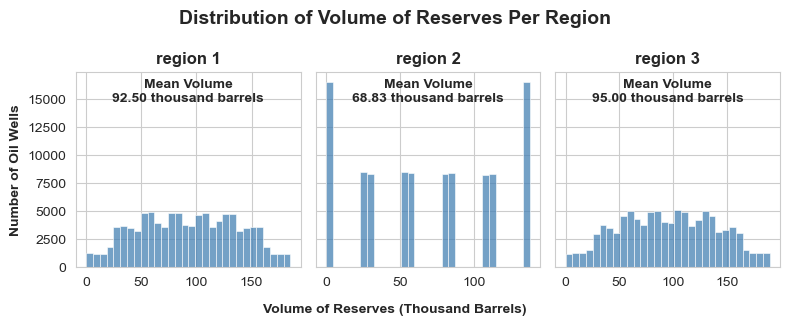

In [7]:
# Plot histograms to show the distribution of volumes
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(8,3))

plt.suptitle('Distribution of Volume of Reserves Per Region', fontsize=14, fontweight='bold')

for i, region in enumerate(regions):
    sns.histplot(x=data[region]['product'], bins=30, color='steelblue', ax=axs[i])
    axs[i].set_title(region, fontsize=12, fontweight='bold')
    axs[i].set_xlabel('')
    
    # Show the mean volume for each region
    mean_volume = data[region]['product'].mean()
    axs[i].text(0.5, 0.85, f'Mean Volume\n{mean_volume:.2f} thousand barrels', fontweight='bold',
                transform=axs[i].transAxes, ha='center')

# x and y labels
fig.text(0.5, -0.03, 'Volume of Reserves (Thousand Barrels)', fontweight='bold', ha='center')
axs[0].set_ylabel('Number of Oil Wells', fontweight='bold')

plt.tight_layout()
plt.show()

The mean volumes of reserves in `region 1` and `region 3` are a lot higher than that of `region 2`. The OilyGiant company plans to choose one of the three regions and select 200 oil wells which have the highest possible volumes of reserves. If the oil wells are chosen randomly, `region 1` or `region 3` will have the best chance to select the wells with higher volume. 

However, it is noticed that there are more than 15000 oil wells in `region 2` have very high volume of reserves (about 140 thousand barrels). By making the volume predictions with a machine learning model, there will be a higher chance to select these oil wells with high volume of reserves. Therefore, `region 2` is also a potential candidate to give a high profit.

[Back to Contents](#back)

### 3.3 Correlation between the Numerical Data <a id='numerical_data_eda'></a>

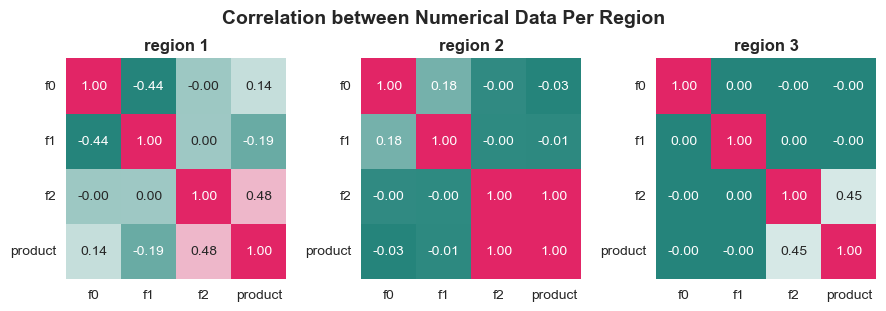

In [8]:
# Show the correlation of the numerical data
sns.set_style('white')
fig, axs = plt.subplots(1, 3, figsize=(9,3))

plt.suptitle('Correlation between Numerical Data Per Region', fontsize=14, fontweight='bold')

for i, region in enumerate(regions):
    sns.heatmap(data[region].drop(columns=['id']).corr(), annot=True, fmt='.2f',
                cmap=sns.diverging_palette(180, 0, s=90, as_cmap=True),
                square=True, cbar=False, ax=axs[i])
    axs[i].set_title(region, fontsize=12, fontweight='bold')    
    tick_labels = axs[i].get_yticklabels()
    axs[i].set_yticklabels(tick_labels, rotation=0)

plt.tight_layout()
plt.show()

For all the three regions, the `f2` feature is the dominant indicator for a machine learning algorithm to predict the values of `product`. In the case of `region 1`, the `f1` and `f2` features have a weak relationship with the features. On the other hand, `f1` and `f2` appear to have little or no impact on predicting the `product` target for `region 2` and `region 3`.

[Back to Contents](#back)

## 4. Development of the Models <a id='models'></a>

---

The functions below will automate the tasks in this stage.

In [9]:
def model_train_pred(dataset):
    '''
    This function split the dataset into train and validation sets
    A baseline model and a linear regresion model will be trained
    Models are evaluated on rmse and r2
    Return the linear regression model, the model result
    and the dataframe consisting actual and predicted volumes of oil wells
    '''
    # Separate the dataset into train and validation sets
    X = dataset[['f0', 'f1', 'f2']]
    y = dataset['product']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=12345)
    
    # Feature scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    
    # Train and predict with a baseline model
    base_model = DummyRegressor(strategy='mean')
    base_model.fit(X_train, y_train)
    base_pred = base_model.predict(X_val)
    baseline_rmse = round(np.sqrt(mean_squared_error(y_val, base_pred)), 4)    
    
    # Train and predict with a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)    
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 4)
    r2 = round(r2_score(y_val, y_pred), 4)
    
    # Result of the baseline and linear regression models
    result = {}
    result['baseline_rmse'] = baseline_rmse      
    result['rmse'] = rmse
    result['r2'] = r2
    result['actual_avg_vol'] = np.mean(y_val)
    result['predicted_avg_vol'] = np.mean(y_pred)    
    
    # Create a dataframe containing the actual and predicted values for each oil well
    temp_df1 = pd.concat([dataset['id'], y_val], join='inner', axis=1)
    temp_df2 = pd.concat([y_val.reset_index(drop=True), pd.Series(y_pred)], axis=1)        
    actual_pred_vol = temp_df1.merge(temp_df2, on='product')
    actual_pred_vol.columns = ['id', 'actual_volume', 'predicted_volume']

    return model, result, actual_pred_vol

In [10]:
def calc_profit(vol_pred, vol_actual, budget, develop_pts, revenue_per_unit):
    '''
    This function selected the most profitable oil wells from the
    prediction of a machine learning model and calculates 
    the profit of these selected wells with the actual values 
    '''
    selected_pts_index = vol_pred.nlargest(develop_pts).index
    selected_pts_vol = vol_actual[selected_pts_index]
    
    profit = selected_pts_vol.sum() * revenue_per_unit - budget
    
    return profit

----

In this project, to predict the volume of reserves, a linear regression model will be trained for each region. The model performance will be evaluated on the root mean squared error. A baseline model which always predicts the mean volume will be trained to provide the baseline rmse for reference.

In [11]:
# Create three dictionaries to store the model, model result and actual_pred_vol
model = {}
model_result = {}
actual_pred_vol = {}

# Train the models and return the results
for region in regions:
    model[region], model_result[region], actual_pred_vol[region] = model_train_pred(data[region])    

### 4.1 Model Performance and Results <a id='model_result'></a>

In [12]:
# Combining the model_results from three regions
model_data = []

for _, value in model_result.items():
    model_data.append(value)

model_result_df = pd.DataFrame({'region': regions, 'data': model_data})
model_result_df = pd.concat([model_result_df['region'], pd.json_normalize(model_result_df['data'])], axis=1)

In [13]:
# Have a look at the actual and predicted volumes in each region
for region in regions:
    print('\033[1m')
    print(region)
    display(actual_pred_vol[region].head(3))
    
# Have a look at the model_result_df
display(model_result_df)


region 1


,id,actual_volume,predicted_volume
0,2acmU,73.037750,116.227394
1,409Wp,85.265647,88.750254
2,iJLyR,168.620776,95.419237



region 2


,id,actual_volume,predicted_volume
0,62mP7,26.953261,29.219306
1,62mP7,26.953261,27.133366
2,62mP7,26.953261,27.627772



region 3


,id,actual_volume,predicted_volume
0,WJtFt,56.069697,66.329664
1,ovLUW,62.871910,48.880039
2,q6cA6,114.572842,86.178035


,region,baseline_rmse,rmse,r2,actual_avg_vol,predicted_avg_vol
0,region 1,44.2896,37.5794,0.2799,92.078597,92.592568
1,region 2,46.0214,0.8931,0.9996,68.723136,68.728547
2,region 3,44.9023,40.0297,0.2052,94.884233,94.965046


The rmse values of all the three linear regression models are lower than the baseline values. 

The model for `region 2` gives the most accurate prediction among the three regions with a rmse of 0.8931. A r2 score of 99.96% means that 99.96% of the variation in the `product` variable is explained by the three features.

Although the predicted volume for each well is not very accurate in the `region 1` and `region 3`,  the predicted average volumes from the three models are very close to the actual average volumes. This infers that the predictions are still useful when the number of wells is substantial and it is crucial to predict the overall profit from a large number of selected oil wells.

In [14]:
# Have a look at how the volume is predicted by the three features
for region in regions:
    print('\033[1m')
    print(f'Model for', region)
    print('\033[0m')
    print('Coefficients of features')
    print('f0:', f'{model[region].coef_[0]:.2f}')
    print('f1:', f'{model[region].coef_[1]:.2f}')
    print('f2:', f'{model[region].coef_[2]:.2f}', '\n')
    print('y-intercept:', f'{model[region].intercept_:.2f}', '\n')
    print('*' * 30)


Model for region 1

Coefficients of features
f0: 3.13
f1: -7.11
f2: 21.43 

y-intercept: 92.64 

******************************

Model for region 2

Coefficients of features
f0: -1.30
f1: -0.11
f2: 45.89 

y-intercept: 68.86 

******************************

Model for region 3

Coefficients of features
f0: 0.05
f1: -0.07
f2: 19.82 

y-intercept: 95.04 

******************************


The `product` in each region is predicted as follow:

$$\begin{align*}
\text{product}_\text{region 1} &= 3.13 \times \text{f0} - 7.11 \times \text{f1} + 21.43 \times \text{f2} + 92.64\\
\text{product}_\text{region 2} &= -1.30 \times \text{f0} - 0.11 \times \text{f1} + 45.89 \times \text{f2} + 68.86\\
\text{product}_\text{region 3} &= 0.05 \times \text{f0} -0.07 \times \text{f1} + 19.82 \times \text{f2} + 95.04
\end{align*}$$

As we have concluded in the EDA stage, the amount of the product are mostly determined by the `f2` feature, except that `f0` and `f1` have some minor impacts on `product` in `region 1`.

[Back to Contents](#back)

## 5.0 Profit Calculation and Risk Assessment <a id='profit_and_risk'></a>

### 5.1 Conditions and the Key Values <a id='conditions'></a>

As informed by the OilyGiant company, 
- When exploring a region, a study of 500 points is carried out and the best 200 points are picked for the profit calculation.
- The budget for development of 200 oil wells is 100 million USD.
- One barrel of raw materials generates 4.5 USD of revenue. Since the volume of reserves is in thousand barrels, the revenue from one unit of product is 4500 USD.
- After the risk evaluation, keep only the regions with the riks of losses lower than 2.5%. From the ones which fit the criteria, the region with the highest average profit should be selected.

In [15]:
# Store the key values
budget = 100e6
explore_pts = 500
develop_pts = 200
revenue_per_barrel = 4.5
revenue_per_unit = 4500
acceptable_risk = 0.025

[Back to Contents](#back)

### 5.2 Minimum Volume of Reserves Per Oil Well Without Losses <a id='minimum_volume'></a>

In [16]:
# Calculate the volume of reserves per oil well without losses
min_volume_per_well = budget / develop_pts / revenue_per_unit

# Print the result
print('The minimum volume of reserves per oil well without losses: ', end='')
print(f'{min_volume_per_well:.2f}\n')

for region in regions:
    print(f'The predicted volume of reserves per oil well in {region}: ', end='')
    print(f'{model_result[region]["predicted_avg_vol"]:.2f}')

The minimum volume of reserves per oil well without losses: 111.11

The predicted volume of reserves per oil well in region 1: 92.59
The predicted volume of reserves per oil well in region 2: 68.73
The predicted volume of reserves per oil well in region 3: 94.97


The minimum volume of reserves per oil well without losses is 111.11. In all three regions, the predicted volume of reserves per oil well does not meet the minimum requirement. Consequently, it is inevitable that the OilyGiant company will suffer a loss if the company randomly selects 200 wells from any of these regions. However, with the prediction from the machine learning model, 200 potential wells with the highest volume of reserves can be chosen.

Next, by utilising the machine learning model, we will examine the profitability of these regions.

[Back to Contents](#back)

### 5.3 Profit from the 200 Oil Wells with the Highest Predicted Volumes Per Region <a id='200_wells'></a>

In each region, out of the 100000 oil wells, the top 200 oil wells with the highest predicted volumes will be selected. Then, the profit will be calculated with the actual volumes of the wells. This allows us to evaluate the profitability of the regions and also validate if the model is applicable in the real-world setting.

In [17]:
# Calculate the profit for each region when 200 top oil wells are selected by prediction
profit = {}

print('For the 200 selected oil wells with the highest predicted volumes\n')
for region in regions:
    profit[region] = calc_profit(
        vol_pred = actual_pred_vol[region]['predicted_volume'], 
        vol_actual = actual_pred_vol[region]['actual_volume'],
        budget = 100e6, 
        develop_pts = 200,
        revenue_per_unit = 4500
    )
    
    print(f'The profit for {region}: {profit[region] / 1e6:.2f} million USD')   

For the 200 selected oil wells with the highest predicted volumes

The profit for region 1: 33.21 million USD
The profit for region 2: 24.15 million USD
The profit for region 3: 27.10 million USD


From the result above, all of the regions has been proven to be profitable when the top 200 oil wells are selected. **Among them, the `region 3` has the highest profit of 33.21 million USD, therefore the best candidate to be chosen and to develop new oil wells is the `region 3`.**

However, in real-world application, it is not practical to explore a huge number of oil wells (100000 in this case) before selecting the top 200 wells since it costs a lot of money, time and manpower. Therefore, it is unlikely the actual profit can be as high as the above mentioned profit by studying  a smaller number of oil wells. In the next section, we will use machine learning and the bootstrapping technique to assess the profitability and the risk when only a small number of oil wells are studied.

[Back to Contents](#back)

### 5.4 Distribution of Profit for Each Region <a id='bootstrapping'></a>

With the limited budget of 100 million USD, the company will only explore 500 oil wells and select 200 of them. After studying the oil wells, the three features `f0`, `f1` and `f2` of the wells are obtained and the volumes can thus be predicted with the pretrained machine learning model. The top 200 wells with the highest predicted volumes of reserves will be selected and developed.

To maximise the profit and minimise the loss, the distribution of profit for each region will be found by the bootstrapping technique with 1000 random samples. In each sample, the top 200 oil wells with the highest volumes are predicted with the machine learning model and the profit is calculated with the actual volumes. From the distribution of the profit, we can calculate the 95% confidence interval of profit and the risk of loss as a percentage of total losses out from 1000 samples.

In [18]:
# Number of total samples and random state value
total_samples = 1000
state = np.random.RandomState(12345)

# Dictionaries to store profits and calculation result
sample_profits = {}
sample_result = {}

# Find the distribution of profits with bootstrapping technique
for region in regions:
    sample_profits[region] = [] # List to store the profits of 1000 samples for each region
    sample_result[region] = {} # Dictionary to store calculation result for each region
    
    # Create 1000 samples and calculate profits
    for i in range(total_samples):
        sample = (actual_pred_vol[region].sample(n=500, replace=True, random_state=state)
                                         .reset_index(drop=True))
                
        sample_profits[region].append(calc_profit(
            vol_pred = sample['predicted_volume'], 
            vol_actual = sample['actual_volume'],
            budget = 100e6, 
            develop_pts = 200,
            revenue_per_unit = 4500
        ))    
    sample_profits[region] = pd.Series(sample_profits[region])
    
    # Calculate the relevant result
    sample_profits[region] = pd.Series(sample_profits[region])
    sample_result[region]['avg_profit'] = sample_profits[region].mean()
    sample_result[region]['95%_CI_lower_bound'] = sample_profits[region].quantile(0.025)
    sample_result[region]['95%_CI_upper_bound'] = sample_profits[region].quantile(0.975)
    sample_result[region]['risk_of_losses'] = f'{sum(sample_profits[region] < 0) / len(sample_profits[region]):.2%}'

Let's have a look at the bootstrapping result.

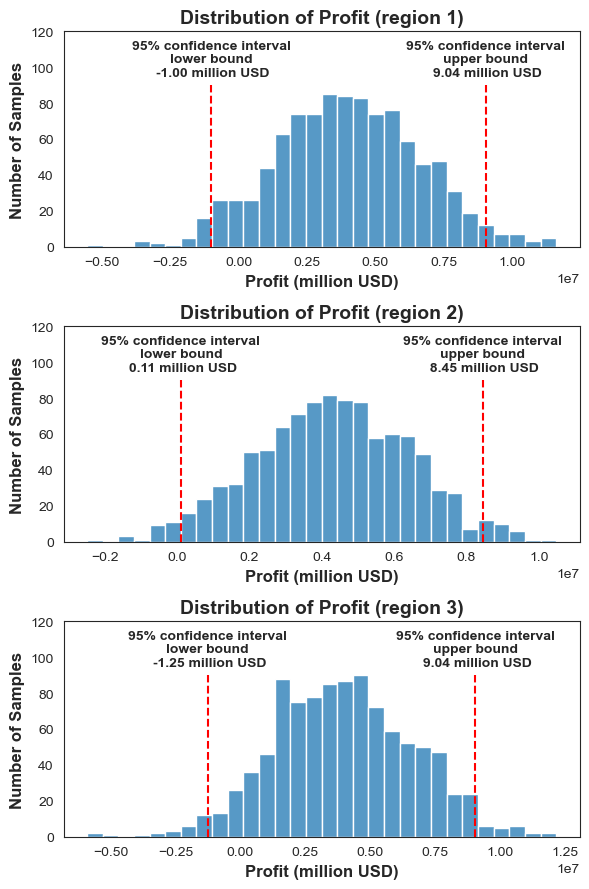

In [19]:
# Plot a histogram to show the distribution of profit for each region
fig, axs = plt.subplots(3, 1, figsize=(6,9))

for i, region in enumerate(regions):
    sns.histplot(x=sample_profits[region], bins=30, ax=axs[i])
    axs[i].set_title(f'Distribution of Profit ({region})', fontsize=14, fontweight='bold')
    axs[i].set_xlabel('Profit (million USD)', fontsize=12, fontweight='bold')
    axs[i].set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    lb = sample_result[region]['95%_CI_lower_bound']
    ub = sample_result[region]['95%_CI_upper_bound']
    axs[i].vlines(x=lb, ymin=0, ymax=90, label='lower', colors='red', ls='--')
    axs[i].text(lb, 95, f'95% confidence interval\nlower bound\n {lb / 1e6:.2f} million USD', fontweight='bold', ha='center')
    axs[i].vlines(x=ub, ymin=0, ymax=90, label='upper', colors='red', ls='--')
    axs[i].text(ub, 95, f'95% confidence interval\nupper bound\n {ub / 1e6:.2f} million USD', fontweight='bold', ha='center')    
    axs[i].set_ylim(0,120)
    
plt.tight_layout()
plt.show()

From the table above, **`region 2` is the only region with the positive lower and upper bounds of the 95% confidence interval for profit**, the confidence interval range from 0.11 million USD to 8.45 million USD. Both `region 1` and `region 3` have negative profit values at the lower bound of the 95% confidence interval.

In [20]:
# Create a dataframe to store the result for each region
region_data = []

for _, value in sample_result.items():
    region_data.append(value)
    
region_result_df = pd.DataFrame({'region': regions, 'data': region_data})
region_result_df = pd.concat([region_result_df['region'], pd.json_normalize(region_result_df['data'])], axis=1)

In [21]:
# Have a look at the bootstrapping result
region_result_df

,region,avg_profit,95%_CI_lower_bound,95%_CI_upper_bound,risk_of_losses
0,region 1,3.995089e+06,-1.001272e+06,9.041102e+06,7.30%
1,region 2,4.281002e+06,1.086722e+05,8.451800e+06,2.10%
2,region 3,3.965886e+06,-1.254271e+06,9.036296e+06,5.80%


From the table above, `region 2` not only has the positive profits at the lower and upper bounds of the 95% confidence intervals, the risk of losses is also the lowest and this risk is lower than the acceptable risk of 2.5%. Besides that, the average profit of 4.28 million USD over 1000 samples is the highest among the three regions. **Therefore, region 2 is the best candidate to be chosen to give the highest profit with a minimal risk.**

[Back to Contents](#back)

## 6.0 General Conclusion <a id='general_conclusion'></a>
**Data Exploration**

The OilyGiant company has provided us three datasets, each for one region. Each dataset contains 100000 oil wells and the relevant information which includes the id of the oil well, the three features `f0`, `f1` and `f2` and the target `product`. The data are sufficient to carry out the model training and the subsequent analysis tasks.

**Exploratory Data Analysis**

- Some of the features have normal distributions while the rest have some unique distribution shapes. 
- The mean volumes of reserves in `region 1` and `region 3` are a lot higher than that of `region 2`. However, it is noticed that there are more than 15000 oil wells in `region 2` have very high volume of reserves (about 140 thousand barrels). 
- For all the three regions, the `f2` feature is the dominant indicator for a machine learning algorithm to predict the values of `product`. In the case of `region 1`, the `f1` and `f2` features have a weak relationship with the features. On the other hand, `f1` and `f2` appear to have little or no impact on predicting the `product` target for `region 2` and `region 3`.

**Development of Models**

A linear regression model is developed for each region to predict the volume of reserves. The rmse values of all the three linear regression models are lower than the baseline values. The model for `region 2` gives the most accurate prediction among the three regions. Although the predicted volumes are not very accurate in the `region 1` and `region 3`,  the predicted average volumes from the three models are very close to the actual average volumes. This is crucial to predict the overall profit from a large number of selected oil wells.

**Profit Calculation and Risk Assessment**

- The minimum volume of reserves per oil well without losses is 111.11. In all three regions, the predicted volume of reserves per oil well does not meet the minimum requirement.
- However, all of the regions has been proven to be profitable when the top 200 oil wells with the highest volumes of reserves are selected. **Among them, the `region 3` has the highest profit of 33.21 million USD, therefore the best candidate to be chosen and to develop new oil wells is the `region 3`.** This approach is not practical since the cost is very high by exploring a huge number of oil wells (100000 in this case) before selecting the top 200 wells.
- By using the bootstrapping technique, the distribution of profit is found for each region. After anslysing the three distributions, **`region 2` stands out as the best candidate to be chosen to give the highest profit with a minimal risk.**

[Back to Contents](#back)

In [22]:
data

{'region 1':           id        f0        f1        f2     product
 0      txEyH  0.705745 -0.497823  1.221170  105.280062
 1      2acmU  1.334711 -0.340164  4.365080   73.037750
 2      409Wp  1.022732  0.151990  1.419926   85.265647
 3      iJLyR -0.032172  0.139033  2.978566  168.620776
 4      Xdl7t  1.988431  0.155413  4.751769  154.036647
 ...      ...       ...       ...       ...         ...
 99995  DLsed  0.971957  0.370953  6.075346  110.744026
 99996  QKivN  1.392429 -0.382606  1.273912  122.346843
 99997  3rnvd  1.029585  0.018787 -1.348308   64.375443
 99998  7kl59  0.998163 -0.528582  1.583869   74.040764
 99999  1CWhH  1.764754 -0.266417  5.722849  149.633246
 
 [100000 rows x 5 columns],
 'region 2':           id         f0         f1        f2     product
 0      kBEdx -15.001348  -8.276000 -0.005876    3.179103
 1      62mP7  14.272088  -3.475083  0.999183   26.953261
 2      vyE1P   6.263187  -5.948386  5.001160  134.766305
 3      KcrkZ -13.081196 -11.506057  4.999